# ML for price modeling



In [1]:
### Import packages

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from haversine import haversine

from sklearn.model_selection import train_test_split

In [2]:
### Constants

CONFIG = {'title': 18,
          'subtitle': 16,
         'label': 14,
         'tick': 12,
         'legend': 14}
RANDOM_SEED = 888

In [3]:
### Database credentials

DB_HOST = os.environ.get('DB_HOST')
DB_PORT = os.environ.get('DB_PORT')
DB_NAME = os.environ.get('DB_NAME')
DB_USERNAME = os.environ.get('DB_USERNAME')
DB_PASSWORD = os.environ.get('DB_PASSWORD')

DB_URL = f'postgresql+psycopg2://{DB_USERNAME}:{DB_PASSWORD}@{DB_HOST}:{DB_PORT}/{DB_NAME}'

In [4]:
### Define functions

def plot_formatting(ax, parameters, config = CONFIG):
    
    # Set labels
    ax.set_xlabel(parameters['x_label'], fontsize = config['label'])
    ax.set_ylabel(parameters['y_label'], fontsize = config['label'])
    
    # Set title
    ax.set_title(parameters['title'], fontsize = config['title'])
    
    # Set tick size
    ax.tick_params(axis = 'both', which = 'major', labelsize = config['tick'])
    
    # Set legend
    ax.legend(loc = 'best', fontsize = config['legend'])

## Getting the data

In [5]:
### Read data from database

try:

    df_dataset = pd.read_sql_table('base_training_data', DB_URL, schema = 'model')
    df_stations = pd.read_sql_table('tfl_stations', DB_URL, schema = 'city')
    df_postcodes = pd.read_sql_table('postcodes', DB_URL, schema = 'city')

    print('Table retrieved successfully.')
except:
    print('Oh oh, something happened mate. Try again.')

Table retrieved successfully.


## Transport score

In [6]:
### Define transport score

def transport_score(df_points, target_lat, target_lon, calibration):

    target_tuple = (target_lat, target_lon)
    latitude_list = df_points['latitude'].tolist()
    longitude_list = df_points['longitude'].tolist()

    source_tuples = [(i, j) for i, j in zip(latitude_list, longitude_list)]
    distance_list = [haversine(i, target_tuple) for i in source_tuples]
    df_points['distance'] = distance_list
    df_points['score_mark'] = df_points['distance'] <= calibration

    score = sum(df_points['score_mark']) / len(df_points['score_mark'])
    return score;

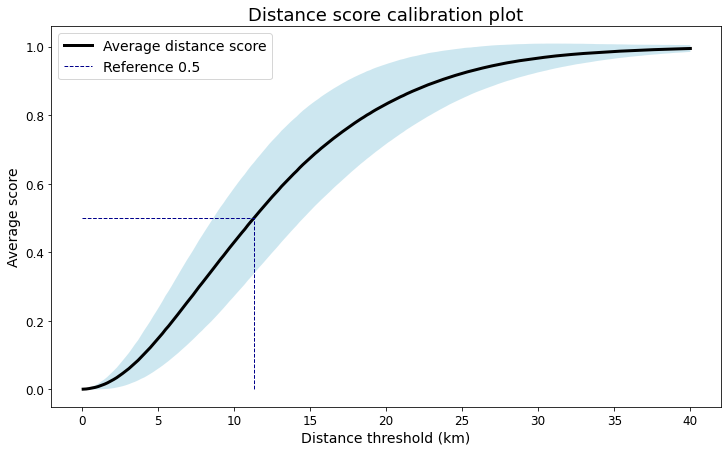

In [7]:
### Score distribution on distance calibration

df_coordinates = df_dataset.sample(1000, random_state = RANDOM_SEED).reset_index(drop = True)

listings_lat = df_coordinates['latitude']
listings_lon = df_coordinates['longitude']

calibration_distance = np.linspace(0.1, 40, 200)
avg_score = []
std_score = []

for i in calibration_distance:
    SCORES = [transport_score(df_stations,
                             listings_lat[j],
                             listings_lon[j],
                             i) for j in range(len(listings_lat))]
    
    AVG_SCORE = np.mean(SCORES)
    STD_SCORE = np.std(SCORES)
    avg_score.append(AVG_SCORE)
    std_score.append(STD_SCORE)
   
# Build plot dataset
df_plot = pd.DataFrame({'cal_distance': calibration_distance,
                       'avg_score': avg_score,
                       'std_score': std_score})

df_plot['lower_shade'] = df_plot['avg_score'] - df_plot['std_score']
df_plot['upper_shade'] = df_plot['avg_score'] + df_plot['std_score']
df_plot['plot_reference'] = np.abs(df_plot['avg_score'] - 0.5)

index_min = df_plot['plot_reference'].idxmin()
reference_point = df_plot[['cal_distance', 'avg_score']].iloc[index_min].values

# Plot
fig = plt.figure(1, (12, 7))
ax = fig.add_subplot(1, 1, 1)

ax.plot(df_plot['cal_distance'],
       df_plot['avg_score'],
       color = 'k',
       linewidth = 3,
       label = 'Average distance score')

# Add shades
ax.fill_between(df_plot['cal_distance'],
                df_plot['lower_shade'],
                df_plot['upper_shade'],
                facecolor = '#add8e6', # The fill color
                alpha = 0.6)

# Set references
reference_x = [0, reference_point[0], reference_point[0]]
reference_y = [reference_point[1], reference_point[1], 0]

ax.plot(reference_x,
       reference_y,
       color = '#00008b',
       linewidth = 1,
       label = 'Reference 0.5',
       linestyle = '--')

# Format plot
plot_params = {'title': 'Distance score calibration plot',
             'x_label': 'Distance threshold (km)',
             'y_label': 'Average score'}

plot_formatting(ax, plot_params)
    
plt.show()

In [8]:
### Merge station to dataframe

df_dataset_merged = df_dataset.copy()

listings_lat = df_dataset_merged['latitude']
listings_lon = df_dataset_merged['longitude']

score_stations = [transport_score(df_stations,
                                  listings_lat[j],
                                  listings_lon[j],
                                  10) for j in range(len(listings_lat))]

df_dataset_merged['score_stations'] = score_stations

## Initial visualisation, merging and set partition

In [9]:
### Dataset info

df_dataset_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66641 entries, 0 to 66640
Data columns (total 33 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   listing_id            66641 non-null  int64         
 1   host_id               66641 non-null  int64         
 2   neighbourhood_id      66641 non-null  int64         
 3   latitude              66641 non-null  float64       
 4   longitude             66641 non-null  float64       
 5   property_type         66641 non-null  object        
 6   room_type             66641 non-null  object        
 7   accommodates          66641 non-null  int64         
 8   bathrooms_text        66397 non-null  object        
 9   bedrooms              62624 non-null  float64       
 10  beds                  62995 non-null  float64       
 11  price_per_night       65611 non-null  float64       
 12  minimum_nights        66641 non-null  int64         
 13  maximum_nights  

In [10]:
### Compute host seniority and neighbourhood zone

df_dataset_merged_processed = df_dataset_merged.copy()

df_dataset_merged_processed['date_reference'] = pd.to_datetime('2021-12-31')
df_dataset_merged_processed['seniority'] = (df_dataset_merged_processed['date_reference'] - df_dataset_merged_processed['host_since']) / pd.pandas.Timedelta(days=365)
df_dataset_merged_processed['seniority'] = np.round(pd.to_numeric(df_dataset_merged_processed['seniority']), 0)

# Merge zone
COLS_POSTCODES = ['neighbourhood_id', 'district', 'postcode_area']
df_postcodes_grouped = df_postcodes[COLS_POSTCODES].groupby(COLS_POSTCODES, as_index = False).size()
df_postcodes_grouped.sort_values(by = ['neighbourhood_id', 'size'], ascending = [True, False], inplace = True)
df_postcodes_grouped.reset_index(drop = True, inplace = True)
df_postcodes_grouped.drop_duplicates(subset = 'neighbourhood_id', keep = 'first', inplace = True)
df_postcodes_grouped.reset_index(drop = True, inplace = True)

df_dataset_merged_processed = pd.merge(df_dataset_merged_processed,
                                      df_postcodes_grouped[['neighbourhood_id', 'postcode_area']].rename(columns = {'postcode_area': 'zone'}),
                                      how = 'left',
                                      on = 'neighbourhood_id')

Average price per night: £116.71
Median price per night: £80.0



/opt/anaconda/envs/Python3/lib/python3.8/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/opt/anaconda/envs/Python3/lib/python3.8/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


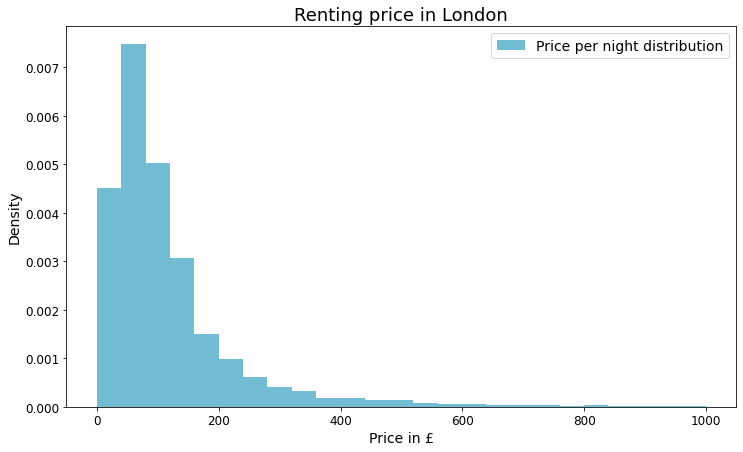

In [11]:
### Explore target - price

avg_price = np.round(df_dataset_merged_processed['price_per_night'].mean(), 2)
median_price = np.round(df_dataset_merged_processed['price_per_night'].median(), 2)

print(f'Average price per night: £{avg_price}')
print(f'Median price per night: £{median_price}\n')

# Plot price distribution
fig = plt.figure(1, (12, 7))
ax = fig.add_subplot(1, 1, 1)

ax.hist(df_dataset_merged_processed['price_per_night'],
       bins = 25,
       density = True,
       color = '#72bcd4',
       label = 'Price per night distribution')

# Format plot
plot_params = {'title': 'Renting price in London',
             'x_label': 'Price in £',
             'y_label': 'Density'}

plot_formatting(ax, plot_params)

plt.show()

/opt/anaconda/envs/Python3/lib/python3.8/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/opt/anaconda/envs/Python3/lib/python3.8/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
/opt/anaconda/envs/Python3/lib/python3.8/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/opt/anaconda/envs/Python3/lib/python3.8/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
/opt/anaconda/envs/Python3/lib/python3.8/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/opt/anaconda/envs/Python3/lib/python3.8/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_eq

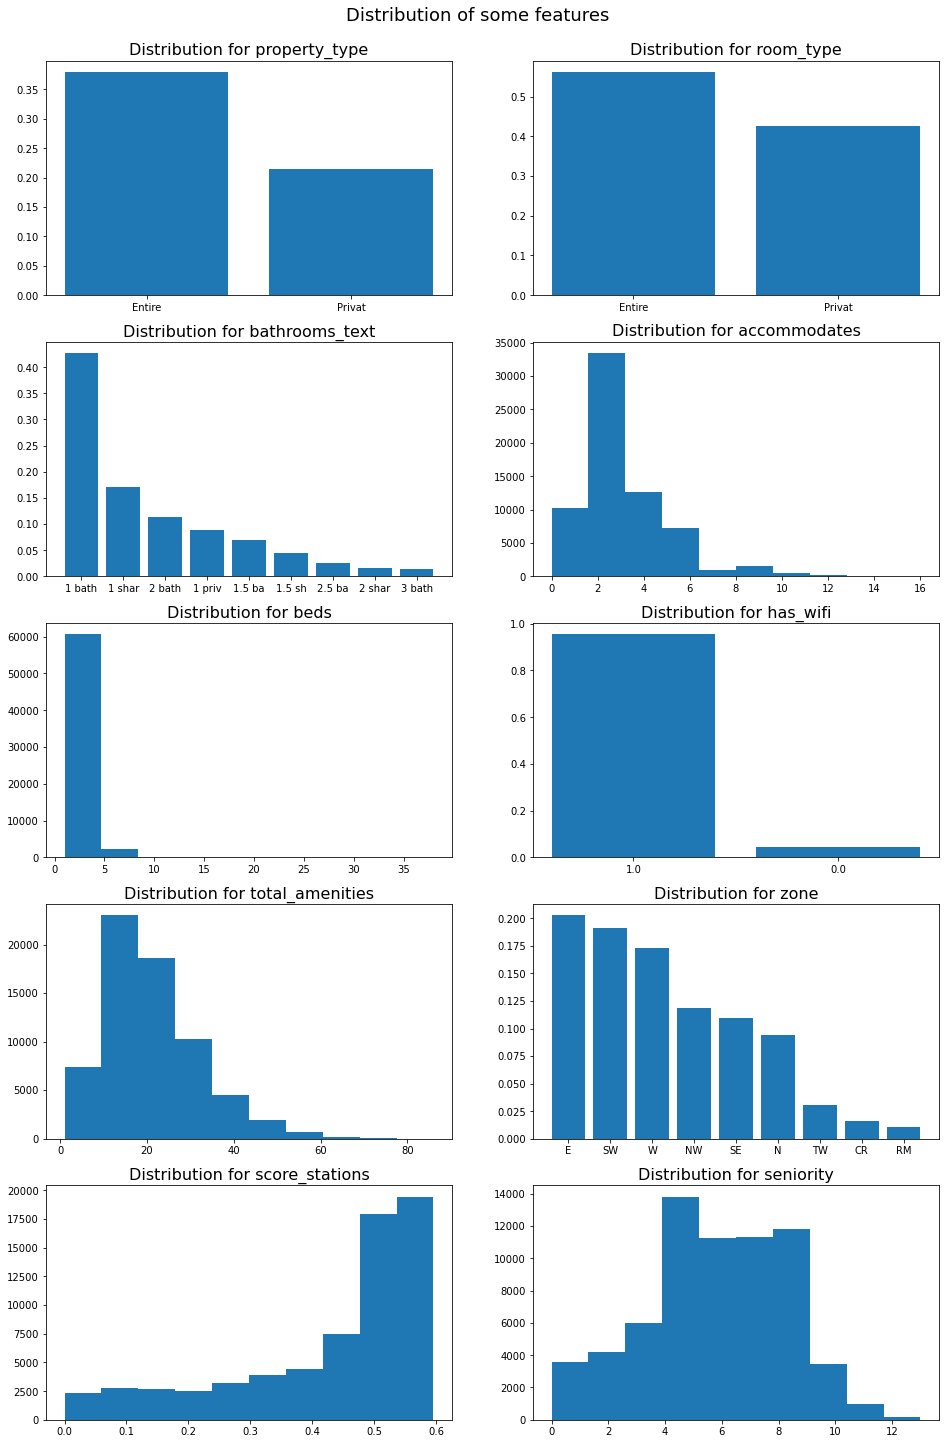

In [12]:
### Show some distribution examples

FEAT_TYPE = {'property_type': 'categorical',
            'room_type': 'categorical',
            'bathrooms_text': 'categorical',
            'accommodates': 'numeric',
             'beds': 'numeric',
            'has_wifi': 'categorical',
            'total_amenities': 'numeric',
            'zone': 'categorical',
            'score_stations': 'numeric',
            'seniority': 'numeric'}

# Plot distributions
fig, axs = plt.subplots(5, 2, figsize = (16, 25)) # Create figure and axes

for POS, FEATURE in enumerate(FEAT_TYPE):

    X_POS = POS // 2
    Y_POS = POS % 2

    if(FEAT_TYPE[FEATURE] == 'numeric'): # Histograms for numeric features

        axs[X_POS, Y_POS].hist(df_dataset_merged_processed[FEATURE])
            
    else:
        
        DIST = pd.DataFrame(df_dataset_merged_processed[FEATURE].value_counts(normalize = True)).reset_index()
        DIST = DIST[DIST[FEATURE] > 0.01]
        DIST['index'] = DIST['index'].apply(str)
        DIST['index'] = DIST['index'].str[:6]
        
        axs[X_POS, Y_POS].bar(DIST['index'],
                             DIST[FEATURE]) # Barplot for categorical features
        
#     axs[X_POS, Y_POS].set_xlabel(FEATURE, fontsize = FONT_SIZE['label']) # Set label of each feature
    axs[X_POS, Y_POS].set_title('Distribution for ' + FEATURE, fontsize = CONFIG['subtitle']) # Set subtitle of each feature
    
    
plt.suptitle('Distribution of some features',
             fontsize = CONFIG['title'],
             y = 0.91) # Main title of the plot
plt.show()

In [13]:
### Partition sets

df_train, df_test = train_test_split(df_dataset_merged_processed,
                                     train_size = 0.8,
                                     random_state = RANDOM_SEED)

print('Size of training set: %s rows' % df_train.shape[0])
print('Size of test set: %s rows' % df_test.shape[0])

Size of training set: 53312 rows
Size of test set: 13329 rows


## Exploratory data analysis